第7章　平均性能の解析に向けて
==

経験エビデンス（再訪）
--

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.font_manager import FontProperties

font_path = u'/Library/Fonts/ヒラギノ角ゴ Pro W3.otf'
font_prop = FontProperties(fname=font_path)
plt.rc('font',family=font_prop.get_name())

In [572]:
class NumericalExample3(object):
    """ 数値例 """
    def __init__(self, n=100, m=200, k=4):
        """ 
        n 行数
        m 列数
        k 非ゼロの要素数 
        A 冗長なシステム行列 mxn
        x スパースな解 m
        y ノイズを含まない観測 n
        e ノイズ n
        b ノイズを含む観測 n
        S サポート m
        mu Aの相互コヒーレンス
        """
        # 冗長なシステム行列A
        self.A = np.random.randn(n, m)
        self.A = np.dot(self.A, np.diag(1. / np.sqrt(np.diag(np.dot(self.A.T, self.A)))))    
        
        #　スパースなx
        self.x = np.zeros(m)
        ndx = np.random.randint(0, m - 1, k)
        self.x[ndx] = np.random.randn(k)
        
        # 雑音を含まない観測
        self.y = np.dot(self.A, self.x)
        self.x /= np.sqrt(np.dot(self.y, self.y))
        self.y = np.dot(self.A, self.x)
        
        # 雑音
        self.e = np.random.randn(n)
        self.e /= np.sqrt(np.dot(self.e, self.e)) * 10

        # 雑音を含む観測b
        self.b = self.y + self.e
        
        # サポートS
        self.S = np.zeros(m, dtype=np.uint8)
        self.S[ndx] = 1
        
        # Aの相互コヒーレンス
        G = np.dot(self.A.T, self.A)
        G[range(m), range(m)] = 0.
        self.mu = np.abs(G).max()

In [573]:
from sklearn.linear_model import LinearRegression

class Greedy(object):
    """ 貪欲法 """
    def __init__(self, A, b, eps=1e-4):
        """
        A m×n行列
        b n要素の観測
        eps 誤差の閾値
        """
        self.A = A
        self.b = b
        self.eps = eps

    def OMP(self):
        """ 直交マッチング追跡(orthogonal matching pursuit; OMP) """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)
        for _ in range(self.A.shape[1]):
            # 誤差計算
            err = rr - np.dot(self.A[:, S == 0].T, r) ** 2
            
            # サポート更新
            ndx = np.where(S == 0)[0]
            S[ndx[err.argmin()]] = 1
    
            # 解更新
            As = self.A[:, S == 1]
            if False:
                lr = LinearRegression(n_jobs=2)
                lr.fit(As, self.b)
                x[S == 1] = lr.coef_
            else:
                pinv = np.linalg.pinv(np.dot(As, As.T))
                x[S == 1] = np.dot(As.T, np.dot(pinv, self.b))
                
            # 残差更新
            r = self.b - np.dot(self.A, x)
            rr = np.dot(r, r)
            if rr < self.eps:
                break
                
        return x, S
    
    def MP(self):
        """ マッチング追跡(matching pursuit; MP) """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)
        for _ in range(1000):
            # 誤差計算
            err = rr - np.dot(self.A.T, r) ** 2

            # サポート更新
            j = err.argmin()
            S[j] = 1
    
            # 解更新
            a = self.A[:, j]
            z = np.dot(a, r)
            x[j] += z
    
            # 残差更新
            r -= z * a
            rr = np.dot(r, r)
            if rr < self.eps:
                break
                
        return x, S

    def WMP(self, t=0.5):
        """ 
        弱マッチング追跡(weak matching pursuit; WMP)     
        t スカラー(0<t<1)
        """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)
        for _ in range(1000):
            # 誤差計算
            max_zz = 0
            j0 = 0
            for j in range(self.A.shape[1]):
                a = self.A[:, j]
                z = np.dot(a, r)
                if np.abs(z) > t * np.sqrt(rr):
                    j0 = j
                    break
                if z ** 2 > max_zz:
                    max_zz = z ** 2
                    j0 = j 
    
            # サポート更新
            S[j0] = 1
    
            # 解更新
            a = self.A[:, j0]
            z = np.dot(a, r)
            x[j0] += z
    
            # 残差更新
            r -= z * a
            rr = np.dot(r, r)
            if rr < self.eps:
                break
                
        return x, S

    def Threshold(self, k):
        """ 
        閾値アルゴリズム(thresholding algorithm) 
        k 列の個数
        """
        # 初期化
        x = np.zeros(self.A.shape[1])
        S = np.zeros(self.A.shape[1], dtype=np.uint8)
        r = self.b.copy()
        rr = np.dot(r, r)

        # 誤差計算
        err = rr - np.dot(self.A.T, r) ** 2

        # サポートの更新
        ndx = np.argsort(err)[:k]
        S[ndx] = 1
        
        # 解更新
        As = self.A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S == 1] = np.dot(As.T, np.dot(pinv, self.b))
        
        return x, S

In [585]:
def get_rel_err(x, x0, e):
    """ 相対誤差 """
    sse = np.dot(x - x0, x - x0)    
    rel_err = sse / np.dot(x0, x0)
    rel_err2 = sse / np.dot(e, e)
    return rel_err, rel_err2

def eval_mean_performance(method, kmin=1, kmax=70, niter=100, noisy=False):
    """ 平均性能の評価 """
    succs = []
    mean_rel_errs = []
    mean_rel_err2s = []
    for k in range(kmin, kmax + 1):
        succ = 0
        mean_rel_err = 0.
        mean_rel_err2 = 0.
        for _ in range(niter):
            nr = NumericalExample3(k=k)
            if method == 'OMP':
                if noisy:
                    greedy = Greedy(nr.A, nr.b, eps=0.01)
                else:
                    greedy = Greedy(nr.A, nr.y, eps=1e-6)
                x, _ = greedy.OMP()
            elif method == 'LARS':
                if noisy:
                    lars = LassoLars(alpha=1e-6, max_iter=10000)
                    lars.fit(nr.A, nr.b)
                else:
                    lars = LassoLars(alpha=1e-6, max_iter=10000)
                    lars.fit(nr.A, nr.y)
                x = lars.coef_
            rel_err, rel_err2 = get_rel_err(x, nr.x, nr.e)
            if rel_err < 1e-5:
                succ += 1
            mean_rel_err += rel_err
            mean_rel_err2 += rel_err2
        mean_rel_err /= niter
        mean_rel_err2 /= niter
        print(k, succ, mean_rel_err, mean_rel_err2)
        succs.append(succ)
        mean_rel_errs.append(mean_rel_err)
        mean_rel_err2s.append(mean_rel_err2)
    return succs, mean_rel_errs, mean_rel_err2s

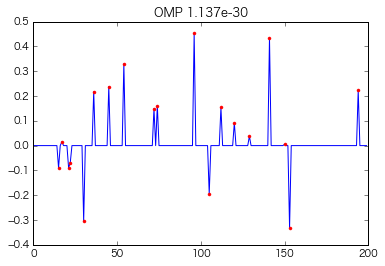

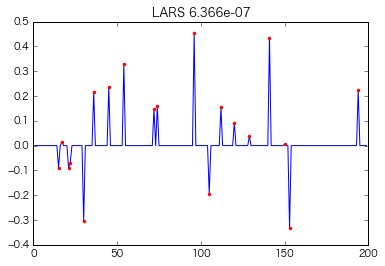

In [586]:
from sklearn.linear_model import LassoLars

k = 20
nr = NumericalExample3(k=k)
greedy = Greedy(nr.A, nr.y, eps=1e-6) 
x1, _ = greedy.OMP()
lars = LassoLars(alpha=1e-6, max_iter=10000)
lars.fit(nr.A, nr.y)
x2 = lars.coef_

def plot(x, x0, title=''):
    plt.figure()
    plt.plot(x)
    ndx = np.where(x0 != 0)[0]
    plt.plot(ndx, x0[ndx], '.r')
    plt.title(title)
    
plot(x1, nr.x, 'OMP {:.3e}'.format(np.dot(x1 - nr.x, x1 - nr.x) / np.dot(nr.x, nr.x)))
plot(x2, nr.x, 'LARS {:.3e}'.format(np.dot(x2 - nr.x, x2 - nr.x) / np.dot(nr.x, nr.x)))

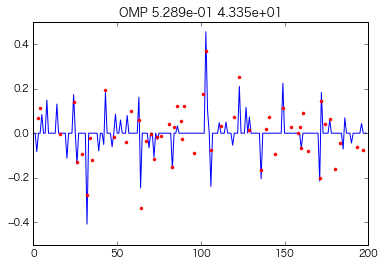

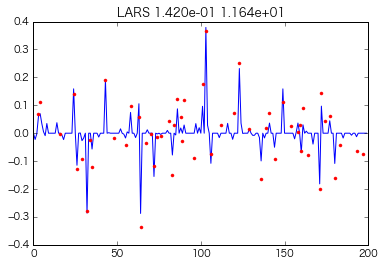

In [588]:
k = 70
nr = NumericalExample3(k=k)
greedy = Greedy(nr.A, nr.b, eps=0.01) 
x1, _ = greedy.OMP()
lars = LassoLars(alpha=1e-4, max_iter=10000)
lars.fit(nr.A, nr.b)
x2 = lars.coef_

err1 = get_rel_err(x1, nr.x, nr.e)
err2 = get_rel_err(x2, nr.x, nr.e)
plot(x1, nr.x, 'OMP {:.3e} {:.3e}'.format(err1[0], err1[1]))
plot(x2, nr.x, 'LARS {:.3e} {:.3e}'.format(err2[0], err2[1]))

In [512]:
k = 10
nr = NumericalExample3(k=k)
# for eps in np.linspace(0.001, 0.02, 20):
for eps in np.logspace(-10, 1, 12):
    greedy = Greedy(nr.A, nr.b, eps=eps) 
    x, _ = greedy.OMP()
    print(eps, get_rel_err(x, nr.x, nr.e))

1e-10 (0.032158560321900398, 3.4024760277085391)
1e-09 (0.032182398096061153, 3.4049981385967141)
1e-08 (0.032273599852296671, 3.414647568986946)
1e-07 (0.032216325215715297, 3.4085877337202808)
1e-06 (0.031802278929220551, 3.3647803446438265)
1e-05 (0.028857104675641281, 3.0531717186692515)
0.0001 (0.027023933310303144, 2.8592164680980048)
0.001 (0.019618296990951235, 2.0756770374051845)
0.01 (0.0011880879423458576, 0.12570341153886763)
0.1 (0.067678953993385735, 7.1606445138672159)
1.0 (0.73118735883421215, 77.361904118035767)
10.0 (0.73118735883421215, 77.361904118035767)


In [398]:
succs, mean_rel_errs, mean_rel_err2s = eval_mean_performance(method='OMP')

1 100 9.39237515279e-32 0.0
2 100 1.47878659576e-31 0.0
3 100 1.27853736133e-30 0.0
4 100 2.03981745854e-10 0.0
5 100 1.27262625942e-10 0.0
6 100 1.49769108697e-30 0.0
7 100 1.53016852947e-30 0.0
8 100 6.11555287875e-09 0.0
9 100 1.12467014126e-08 0.0
10 100 1.03760778479e-09 0.0
11 100 2.70009685765e-08 0.0
12 100 1.09724621835e-08 0.0
13 100 5.86694307935e-09 0.0
14 100 1.18473456521e-08 0.0
15 100 3.82198272623e-08 0.0
16 100 3.65076254585e-08 0.0
17 100 2.02852227974e-08 0.0
18 100 5.22413118822e-08 0.0
19 100 2.47824771874e-08 0.0
20 100 3.66310550113e-08 0.0
21 100 5.3158555223e-08 0.0
22 100 6.31453541536e-08 0.0
23 100 2.2669839663e-08 0.0
24 100 7.49412729458e-08 0.0
25 100 3.3950142073e-08 0.0
26 100 1.2625748546e-07 0.0
27 100 9.97808021378e-08 0.0
28 100 6.59305864174e-08 0.0
29 100 7.37816025709e-08 0.0
30 100 5.11776553391e-08 0.0
31 100 5.51857070317e-08 0.0
32 100 1.14292284386e-07 0.0
33 100 1.00912141586e-07 0.0
34 100 1.02977754428e-07 0.0
35 98 0.00620201542359 0.0


In [400]:
succs2, mean_rel_errs2, mean_rel_err2s2 = eval_mean_performance(method='LARS')

1 100 1.01439403364e-08 0.0
2 100 2.09995706367e-08 0.0
3 100 3.16343865792e-08 0.0
4 100 4.55293886085e-08 0.0
5 100 5.87595753307e-08 0.0
6 100 7.11585302345e-08 0.0
7 100 8.13260571367e-08 0.0
8 100 9.84335410167e-08 0.0
9 100 1.10582953133e-07 0.0
10 100 1.29454655848e-07 0.0
11 100 1.48376112089e-07 0.0
12 100 1.70739153795e-07 0.0
13 100 1.86986470227e-07 0.0
14 100 2.3109423236e-07 0.0
15 100 2.35864519644e-07 0.0
16 100 2.60163050187e-07 0.0
17 100 3.28103990851e-07 0.0
18 100 3.35816039468e-07 0.0
19 100 4.40262673211e-07 0.0
20 100 4.51182892065e-07 0.0
21 100 6.21188828908e-07 0.0
22 100 6.04088769501e-07 0.0
23 100 7.81036045729e-07 0.0
24 100 7.90369040445e-07 0.0
25 100 9.31702172039e-07 0.0
26 100 1.03557511588e-06 0.0
27 98 1.60710239285e-06 0.0
28 98 2.03229472608e-06 0.0
29 99 2.38058630077e-06 0.0
30 98 2.26155846043e-06 0.0
31 89 1.16922682231e-05 0.0
32 85 0.000119363878773 0.0
33 83 0.00253689301096 0.0
34 80 0.000661662962002 0.0
35 74 0.00195576050137 0.0
36 62 

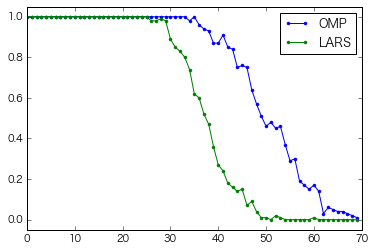

In [401]:
plt.plot(np.array(succs) / 100., '.-', label='OMP')
plt.plot(np.array(succs2) / 100., '.-', label='LARS')
plt.ylim(-0.05, 1.05)
plt.legend()